In [3]:
import numpy as np
import cv2 as cv
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils
import glob
import warnings
import os

In [4]:
TOL = 5
NUM_ITR = 1000
PATHS = namedtuple('_', ('mosaic', 'stereo'))('../images/Image Mosaicing/', '../images/Stereo Correspondence/')

def read_files_q1(idx):
    files = glob.glob(PATHS.mosaic + str(idx) +'_*')
    images = []
    for f in files:
        img = cv.imread(f)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
        images.append(img)
    return images

In [5]:
def get_matches(img1, img2):
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # match
    flann = cv.FlannBasedMatcher({'algorithm': 1, 'trees': 5}, {'checks': 50})
    matches_raw = flann.knnMatch(des1, des2, k=2)

    matches = []
    for m in matches_raw:
        if m[0].distance < 0.7 * m[1].distance:
            matches.append(m)
    
    points1 = np.array([kp1[m[0].queryIdx].pt for m in matches], dtype=np.float64)
    points2 = np.array([kp2[m[0].trainIdx].pt for m in matches], dtype=np.float64)

    return points1, points2

def find_homography(src, dst):
    
    A = [[] for i in range(2 * src.shape[0])]

    for i in range(src.shape[0]):
        Xi = src[i]
        xi = dst[i]
        A[2 * i] = [Xi[0], Xi[1], 1, 0, 0, 0, -xi[0]*Xi[0], -xi[0]*Xi[1], -xi[0]]
        A[(2 * i) + 1] = [0, 0, 0, Xi[0], Xi[1], 1, -xi[1]*Xi[0], -xi[1]*Xi[1], -xi[1]]

    A = np.array(A, dtype=np.float64)
    u, d, vh = np.linalg.svd(A)

    if vh is None:
        warnings.warn('Could not compute H')
        return np.eye(3)

    H = vh[8].reshape((3, 3))
    H = H / H[2, 2]
    return H

def to_homogenous(x):
    return np.concatenate((x, np.ones((x.shape[0], 1))), axis=1)


def project_points(P, X):
    X_ = to_homogenous(X)
    x = P @ X_.T
    x = x / x[2]
    return x.T[:, :2]

def find_homography_ransac(src, dst, tol=TOL, num_itr=NUM_ITR):
    
    best_H = None
    best_thresh = 0

    for i in range(num_itr):
        rand_idx = np.random.choice(dst.shape[0], size=5, replace=False)
        dst_r = dst[rand_idx, :]
        src_r = src[rand_idx, :]

        H = find_homography(src_r, dst_r)
        pred_dst = project_points(H, src)

        count = 0
        for i in range(src.shape[0]):
            e = np.linalg.norm(pred_dst[i, :] - dst[i, :])
            if e < tol:
                count += 1
        
        if count/src.shape[0] >= best_thresh:
            best_H = H
            best_thresh = count/src.shape[0]

    return best_H


In [9]:
def crop(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY)

    cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv.contourArea)
    (x, y, w, h) = cv.boundingRect(c)
    img = img[y:y + h, x:x + w]
    return img

def overlap(img_bot, img_top):
    # pick pixels from img_top and place on img_bot
    for i in range(img_top.shape[0]):
        for j in range(img_top.shape[1]):
            if list(img_bot[i, j, :]) == [0, 0, 0]: # if bottom is black, freely replace
                img_bot[i, j, :] = img_top[i, j, :]
            elif list(img_top[i, j, :]) != [0, 0, 0]: # if bottom is not black, only replace if top is also not black
                img_bot[i, j, :] = img_top[i, j, :]
    return img_bot

def stitch_two(img1, img2): # img1 is new, img2 is base
    points1, points2 = get_matches(img1, img2)
    H = find_homography(points1, points2)

    result_width = img1.shape[1] + img2.shape[1]
    result_height = img1.shape[0] + img2.shape[0]

    img1_ = cv.warpPerspective(img1, H, (result_width, result_height))
    img2 = crop(img2)
    return overlap(img1_, img2)

In [10]:
def panaroma(images):
    if len(images) == 0:
        return
    
    base = images[0]
    for img in images[1:]:
        base = stitch_two(img, base)

    return base

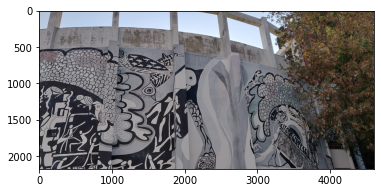

In [8]:
images = read_files_q1(5)
img = panaroma(images)
plt.imshow(img)